# *Reinforcement Learning (RL)*

Fatima Sultana

# [`gymnasium`](https://gymnasium.farama.org/) [`Taxi-v3`](https://gymnasium.farama.org/environments/toy_text/taxi/) 🚕 environment with Q-Learning 🧠 Agent

Objective: Implement a Q-Learning agent that attempts to solve the *Taxi Problem*.



### Reference

Details of the `Taxi-v3` environment are available here: https://gymnasium.farama.org/environments/toy_text/taxi/

## Step 0: Import the dependencies 📚


In [ ]:
!pip install gymnasium --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
import random
import time

In [ ]:
!pip install renderlab --quiet

In [ ]:
import renderlab as rl

## Step 1: Create the environment 🎮




*   Let's create Taxi-v3 environment
*   This environment is part of the Toy Text environments provided by OpenAI Gymnasium.
*   The Taxi Problem entails navigating through a grid world to locate passengers, picking them up, and then dropping them off at their destinations.





In this environment, the setup options are much more limited compared to the FrozenLake-v1 environment. The Taxi-v3 environment does not have configuration parameters such as map_name, is_slippery, or render_mode that we can set during initialization. The environment is predefined and has default settings. Hence only gym.make('Taxi-v3') is used to create the Taxi-v3 environment.

In [ ]:
#Function to display additional information about the environment
def query_environment(env, name):
    print(f"{name} environment information")
    print(f"Action Space          : {env.action_space}")
    print(f"Action Space Size     : {env.action_space.n}")
    print(f"Observation Space     : {env.observation_space}")
    print(f"Observation Space Size: {env.observation_space.n}")
    print(f"Reward Range          : {env.reward_range}")
    print()

#Create the Taxi-v3 environment
env = gym.make('Taxi-v3')

#Query the environment
query_environment(env, "Taxi-v3")

Taxi-v3 environment information
Action Space          : Discrete(6)
Action Space Size     : 6
Observation Space     : Discrete(500)
Observation Space Size: 500
Reward Range          : (-inf, inf)



**Action Space:** There are 6 discrete actions that the agent can choose from. These represent following:

0: Move south (down)

1: Move north (up)

2: Move east (right)

3: Move west (left)

4: Pickup passenger

5: Drop off passenger

**Observation Space:** The environment has 500 discrete states. These states encode various scenarios in which the taxi and the passenger can be, including different locations for the taxi, the passenger, and the destination.

**Reward Range:** The possible range of rewards is from negative infinity to positive infinity, indicating a very flexible reward system that isn't constrained to specific values.

## Step 2: Create the Q-table and initialize it 🗄️


Q-table is crucial for implementing the Q-learning algorithm, as the agent will iteratively update this table based on the rewards received from the environment for taking specific actions in specific states.



*   Creating the Q-table, by calculating the action_size and the state_size
*   OpenAI Gym provides env.action_space.n and env.observation_space.n to do that





In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.n
Q_value = np.zeros((state_size, action_size))

print(Q_value.shape)
print(Q_value.size)

(500, 6)
3000


Q_value is initialized as a two-dimensional NumPy array with dimensions (state_size, action_size), filled with zeros. This array will be used to store the Q-values, where each element (i, j) represents the value of taking action j in state i. This table will guide the agent to take the most rewarding actions, aiming to maximize cumulative rewards.

## Step 3: Specify the hyperparameters ⚙️

Specifying various hyperparameters for configuring a Q-learning algorithm in a reinforcement learning environment, likely for the Taxi-v3 task. These parameters allow fine-tuning of the agent's learning behavior. Adjusting these values can help avoid situations where the agent either learns too slowly (undertraining) or memorizes specific paths rather than generalizing from its experience (overtraining)

In [ ]:
total_episodes = 2000 #1000 #4000 #2000 #500  # Total episodes for training(A higher number to ensure robust learning)
max_steps = 100 #99 #98        #Max steps per episode (Enough steps to allow completion of "long" episodes without looping)

learning_rate = 0.1 #0.7    #rate at which the agent adopts new information
discount_factor = 0.9 #0.99 #0.618    #factor by which future rewards are diminished as they are brought to present value.

#Controlling the exploration-exploitation balance.
exploration_rate = 1.0
min_exploration_rate = 0.01
max_exploration_rate = 1.0
exploration_decay_rate = 0.01  #Adjusted for a more gradual decay over more episodes


Proper tuning of total_episodes and max_steps is essential for achieving a balance between training duration and computational efficiency. We have methodically tested various values for these parameters to optimize our training process. The impact of these various values will be thoroughly analyzed in the observation section to illustrate their effects on the learning performance and efficiency of our model.
The exploration and exploitation balance is fundamental in ensuring that the agent doesn't get stuck in local optima.

## Step 4: Train via the Q-Learning algorithm 🧠


Steps in Q-learning:
1. Initialize the Q-table with zeros (eventually, updating will happen with a reward received for each action taken during learning).
2. Updating of a $Q$ value for a state-action pair, $Q(s,a)$, is given by:

$$Q(s,a)\leftarrow Q(s,a)+\alpha[r+\gamma\max_{a'}Q(s',a')-Q(s,a)]$$

where
* $s$ = current state
* $a$ = action taken (choosing new action through *epsilon-greedy approach*)
* $s'$ = resulting next state
* $a'$ = action taken to get to resulting next state
* $r$ = reward received for taking action $a$
* $\alpha$ = the *learning rate*; that is, the rate at which the learning of the agent converges towards minimized error
* $\gamma$ = the *discount factor* (or *reward decay rate*); that is, discounts future reward to get an    idea of how important that future reward is with regards to the current reward
3. By updating the $Q$ values using the formula in step 2, the table converges to obtain accurate values for an action to take in a given state.

In [ ]:
#Initialize lists to store rewards, Q-table snapshots, states, and actions
rewards = []
history = []
all_states = []
all_actions = []
#Loop through total episodes
for episode in range(total_episodes):
    #Reset the environment
    raw_state = env.reset()
    state = raw_state[0] if isinstance(raw_state, tuple) else raw_state  # Extract state integer if it's a tuple
    total_rewards = 0

    #Loop through steps within each episode
    for step in range(max_steps):
        #Epsilon-greedy action selection
        if random.uniform(0, 1) < exploration_rate:
            action = env.action_space.sample()  # Explore and select a random action
        else:
            action = np.argmax(Q_value[state, :])  # Exploit and select the best action from this state

        #Take the action (a) and observe the reward (r) and resultant state (new_state)
        raw_new_state, reward, done, truncated, info = env.step(action)
        new_state = raw_new_state[0] if isinstance(raw_new_state, tuple) else raw_new_state

        #Q-Learning algorithm update
        Q_value[state, action] = Q_value[state, action] + learning_rate * (
            reward + discount_factor * np.max(Q_value[new_state, :]) - Q_value[state, action])

        #Log all states and actions
        all_states.append(state)
        all_actions.append(action)

        state = new_state  #Update state to new_state
        total_rewards += reward #Add the rewards

        if done:
            break

    #Store Q-table snapshot after each episode (or at another interval)
    if episode % 100 == 0:  # Adjust this interval as needed
        history.append(np.copy(Q_value))

    #Decay the exploration rate
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards.append(total_rewards)

#Calculate and print the average reward per hundred episodes
for i in range(0, total_episodes, 100):
    print(f"Episode {i+1}-{i+100}: Average Reward: {np.mean(rewards[i:i+100])}")


Episode 1-100: Average Reward: -134.84
Episode 101-200: Average Reward: -9.79
Episode 201-300: Average Reward: 2.96
Episode 301-400: Average Reward: 5.71
Episode 401-500: Average Reward: 7.32
Episode 501-600: Average Reward: 7.5
Episode 601-700: Average Reward: 7.01
Episode 701-800: Average Reward: 7.44
Episode 801-900: Average Reward: 7.65
Episode 901-1000: Average Reward: 7.72
Episode 1001-1100: Average Reward: 7.75
Episode 1101-1200: Average Reward: 7.07
Episode 1201-1300: Average Reward: 7.41
Episode 1301-1400: Average Reward: 7.13
Episode 1401-1500: Average Reward: 7.16
Episode 1501-1600: Average Reward: 7.24
Episode 1601-1700: Average Reward: 7.35
Episode 1701-1800: Average Reward: 7.39
Episode 1801-1900: Average Reward: 7.53
Episode 1901-2000: Average Reward: 7.33


Average reward for every 100 episodes is displayed. The rewards start quite negative, indicating early struggles of the learning algorithm to find successful strategies. As episodes progress, there is a noticeable improvement in the average reward, transitioning from negative to positive values, which suggests that the learning algorithm starts to find and exploit successful strategies. After the initial improvement, the average rewards per 100 episodes stabilize around values slightly above 7, indicating that the model has likely converged to a stable policy.

In [ ]:
#Priniting score overall
print ("Score over time: " +  str(sum(rewards)/total_episodes))

Score over time: -0.898


The average score over all episodes of a reinforcement learning task is calculated as -0.898. This indicates that it has learned the key aspects of the task effectively as initially the reward was around -134.

**CHECKING OUT THE Q_TABLE**

In [ ]:
#A function to print Q-table in a readable format with action symbols for clarity
def printQtable(arr):
    #Define action symbols for Taxi-v3
    actions = ["↓", "↑", "→", "←", "Pickup", "Dropoff"]
    print("Q:SxA    ", end=" ")
    for a in actions:
        print("{:8s}".format(a), end=" ")
    print("")

    #Print table contents
    i = 0
    for row in arr:
        print("{:5d}".format(i), end=" ")
        for item in row:
            print("{:8.5f}".format(item), end=" ")
        i += 1
        print("")


#Q-table from your Q-learning training for Taxi-v3
printQtable(Q_value)


Q:SxA     ↓        ↑        →        ←        Pickup   Dropoff  
    0  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000 
    1 -0.02289 -1.63555 -2.34224  0.30496  9.62207 -3.52448 
    2  1.71173  3.09888  0.91133  0.80378 14.11881 -1.06157 
    3 -2.05475 -0.80421 -1.68483 -3.24293 10.72936 -3.74663 
    4 -4.60963 -7.36049 -7.33975 -7.38703 -9.09589 -7.48130 
    5  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000 
    6 -7.30450 -7.58185 -6.65007 -7.49874 -9.95038 -10.55235 
    7 -5.90475 -5.89151 -4.67912 -5.91525 -6.53500 -6.60040 
    8  5.63994 -3.53560 -2.96249 -2.92298 -5.48271 -7.99973 
    9 -0.45365 -6.29095 -6.23949 -6.32555 -7.13687 -7.26797 
   10  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000 
   11  2.62859 -4.54566 -5.07422 -4.90228 -8.59049 -8.82733 
   12 -4.06910 -6.76183 -6.68353 -6.72934 -6.72177 -6.76240 
   13 -3.34551 -5.72403 -5.76253 -5.71853 -5.93266 -7.58900 
   14 -4.11666 -6.41012 -6.40922 -6.46113 -7.84541 -6.56868 
   15  0.00000  0.0

Recall that there are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

The Q-values in the table show how useful each action is expected to be when the agent is in a certain state. Higher values suggest that an action is likely to lead to better outcomes. You can see that some actions have particularly high or low values, which tells us what the agent has learned to prefer or avoid.

### Analysis and Visualizations

**ANALYSIS**

These configuration for a reinforcement learning Taxi-v3 environment play a critical role in determining the efficiency and effectiveness of the learning process.

Total Episodes: More episodes give the agent ample opportunity to explore different strategies, ensuring it learns the most effective paths and actions needed to navigate the environment successfully. This depth of experience is invaluable for the agent to understand the full scope of the state-action space.

Max Steps per Episode: Setting a reasonable limit on steps per episode is essential to avoid infinite loops, ensuring that each session has enough room for the agent to complete its mission of picking up and dropping off passengers efficiently.

Learning Rate: It controls how quickly the agent integrates new information impacting how rapidly the Q-values in the Q-table are updated.

Discount Factor: Discount factor helps the agent to evaluate the long-term outcomes of its actions, by weighting the importance of future rewards, fostering a strategy that looks beyond immediate gains for greater eventual success.

Exploration Parameters: Initially high exploration rates prompt the agent to experiment with different approaches, a critical phase for learning in Taxi-v3's complex and varied environment. Over time, fine-tuning the balance between exploration and exploitation is necessary to refine the agent's strategies towards optimal performance.

These hyperparameters are not just settings but are instrumental tools that guide the learning trajectory of the Taxi-v3 agent. Through strategic adjustment and careful monitoring, they enable the agent to master an effective balance of exploration and exploitation. Ensuring these parameters are optimally set helps the agent to learn effectively as observed above.

**VISUALIZATIONS**

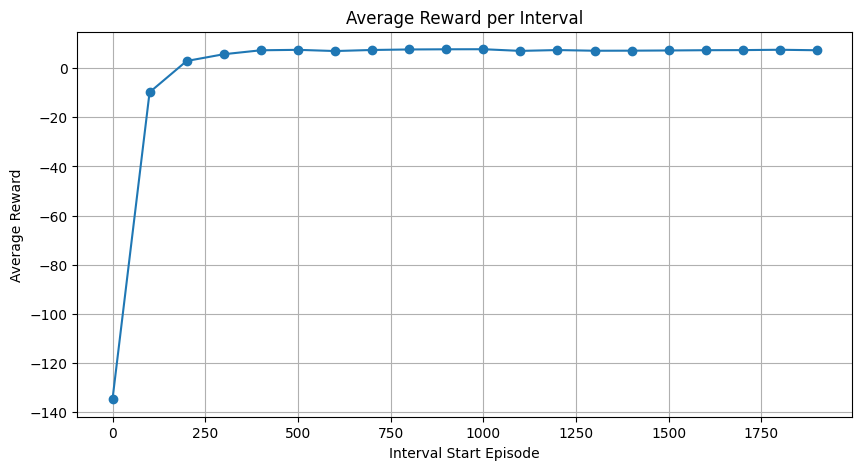

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def process_rewards(rewards, total_episodes, interval=100):
    #Process rewards to calculate the average over specified intervals
    avg_rewards = [np.mean(rewards[i:i + interval]) for i in range(0, total_episodes, interval)]

    #Create a DataFrame for easy plotting
    intervals = range(0, total_episodes, interval)
    df = pd.DataFrame({
        'Interval Start': intervals,
        'Average Reward': avg_rewards
    })

    return df

def plot_rewards(df):
    # Plot the average rewards over intervals
    plt.figure(figsize=(10, 5))
    plt.plot(df['Interval Start'], df['Average Reward'], marker='o')
    plt.title('Average Reward per Interval')
    plt.xlabel('Interval Start Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()

#Define the interval
interval = 100

#Process rewards and plot
df_rewards = process_rewards(rewards, total_episodes, interval)
plot_rewards(df_rewards)


The training regimen appears to be highly effective, with the agent achieving and maintaining a high level of performance after initial learning. The graph implies that the exploration decay rate is set appropriately to reduce exploration as the agent becomes more competent. This ensures that by the time the agent has learned effective strategies, it does not deviate too much into less optimal actions, maintaining a high average reward.

In [ ]:

def qtable_directions_map_taxi(qtable, num_locations=25):
    """Get the best learned action & map it to arrows for Taxi-v3 environment."""
    directions = {0: "↓", 1: "↑", 2: "→", 3: "←", 4: "Pickup", 5: "Dropoff"}
    qtable_val_max = qtable.max(axis=1)
    qtable_best_action = np.argmax(qtable, axis=1)
    qtable_directions = np.empty(qtable_best_action.shape, dtype=object)

    #Mapping the best actions to directions
    for idx, action in enumerate(qtable_best_action):
        if qtable_val_max[idx] > np.finfo(float).eps:  #Checking for meaningful Q-values
            qtable_directions[idx] = directions[action]
        else:
            qtable_directions[idx] = ""  #Empty string for unlearned actions

    #Reshape for visualization if possible
    qtable_directions = qtable_directions.reshape((-1, 5))  #Grid layout for the taxi positions
    return qtable_directions


qtable_directions = qtable_directions_map_taxi(Q_value)
print(qtable_directions)

[['' 'Pickup' 'Pickup' 'Pickup' '']
 ['' '' '' '↓' '']
 ['' '↓' '' '' '']
 ['' 'Dropoff' '↓' '↓' '↓']
 ['' '←' '←' '←' '']
 ['' '' '↓' '↓' '']
 ['' '↓' '' '↓' '']
 ['' '←' '↓' '←' '↓']
 ['' '↓' '↓' '' '→']
 ['' '→' '→' '↓' '']
 ['' '↓' '↓' '→' '→']
 ['' '↓' '→' '' '→']
 ['' '' '' '' '→']
 ['' '→' '→' '↓' '']
 ['' '' '↓' '↓' '↓']
 ['' '' '→' '↓' '↓']
 ['' '' '' '' 'Pickup']
 ['' 'Pickup' 'Pickup' '' '']
 ['' '' '' '←' '']
 ['' '↓' 'Dropoff' '←' '←']
 ['' '↑' '↑' '↑' '']
 ['' '' '' '↓' '↓']
 ['' '↓' '↓' '↓' '↓']
 ['' '↑' '→' '↓' '↓']
 ['' '←' '←' '←' '↓']
 ['' '↓' '↓' '↓' '↓']
 ['' '←' '↓' '↓' '↓']
 ['' '↑' '↓' '↓' '↓']
 ['' '↓' '↓' '↓' '→']
 ['' '→' '→' '↓' '↓']
 ['' '↓' '↓' '→' '→']
 ['' '↓' '→' '↓' '↓']
 ['' '←' '←' '↓' '↑']
 ['' '↑' '↑' '↓' '↓']
 ['' '←' '↓' '↓' '↓']
 ['' '←' '→' '↓' '↓']
 ['' '' '←' '↓' '↑']
 ['' '↑' '↑' '↓' '']
 ['' '' '↓' '←' '←']
 ['' '↓' '↑' '←' '←']
 ['' '↑' '↑' '↑' '→']
 ['' '→' '→' '↓' '↓']
 ['' '↓' '→' '→' '→']
 ['' '↑' '→' '↓' '→']
 ['' '↑' '←' '↑' '→']
 ['

It checks if the maximum Q-value for each state is significant to determine if an action has been effectively learned. The function then maps these actions to human-readable directions like arrows for movement and labels for pickup and dropoff, reshaping the output to a 2D grid that matches the taxi environment's layout, facilitating easier visualization of the learned policy.

Plot to understand distribution of states and actions for Taxi-v3 environment

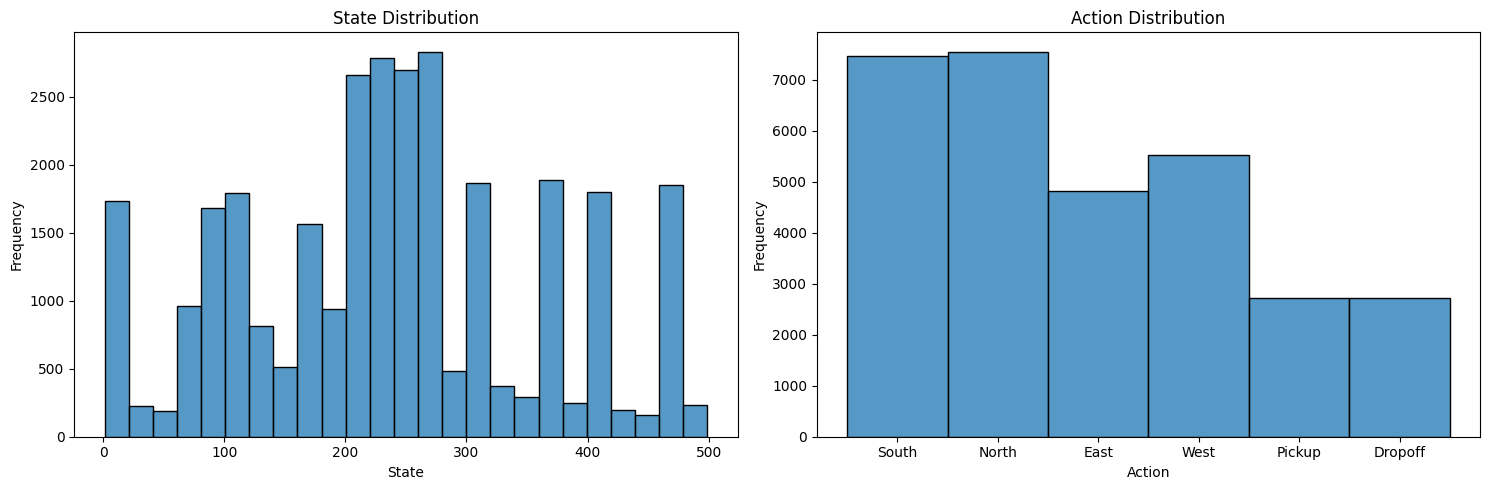

In [ ]:
import seaborn as sns
def plot_states_actions_distribution_taxi_v3(states, actions):
    #Labelling actions
    action_labels = {0: "South", 1: "North", 2: "East", 3: "West", 4: "Pickup", 5: "Dropoff"}
    #Creating a subplots for action and state
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    #Plotting state distributions, assuming states are integers representing taxi positions
    sns.histplot(data=states, ax=ax[0], kde=False, bins=25)
    ax[0].set_title("State Distribution")
    ax[0].set_xlabel("State")
    ax[0].set_ylabel("Frequency")

    #Plotting action distributions
    sns.histplot(data=actions, ax=ax[1], discrete=True)
    ax[1].set_xticks(list(action_labels.keys()))
    ax[1].set_xticklabels(action_labels.values())
    ax[1].set_title("Action Distribution")
    ax[1].set_xlabel("Action")
    ax[1].set_ylabel("Frequency")

    fig.tight_layout()
    plt.show()


plot_states_actions_distribution_taxi_v3(all_states, all_actions)

The plot displays two histograms: one showing the distribution of states and the other showing the distribution of actions within a Taxi-v3 environment.

State Distribution Histogram: The uneven distribution implies that certain states are encountered more often than others, suggesting there are specific areas in the environment where the taxi either frequently travels or tends to get caught.

Action Distribution Histogram: The graph shows a clear preference for certain directions, with 'South' and 'North' actions being the most frequent. The lesser frequency of 'Pickup' and 'Dropoff' actions reflects their specific use cases, only applicable when the taxi is in the correct position to perform these tasks.

## Step 5: Q-Learning 🧠 Agent uses our Q-table to drive the *Taxi* 🚕

Defining a policy function to select actions using a Q-table and simulate a series of episodes in the Taxi-v3 environment to assess the policy's effectiveness. It tracks successful passenger drop-offs and displays each episode's outcome, tallying the success rate over 5 episodes, showcasing the trained agent's ability to execute the task within the environment.

In [ ]:
#Define the policy using the Q-table
def policy(state):
    return np.argmax(Q_value[state, :])

n_episodes = 5
max_steps = 99
success = 0  #Number of successful attempts

for episode in range(n_episodes):
    step = 0
    done = False
    state = env.reset()[0]

    print(f"EPISODE #{episode+1}\n")

    for step in range(max_steps):
        #Use the current policy to determine the next action
        action = policy(state)

        #Update the environment based on the action taken
        new_state, reward, done,truncated, info = env.step(action)

        env.render()  #Optional: to visually see the taxi environment in action

        if done:
            if reward == 20:  #In Taxi-v3, a reward of 20 indicates successful drop-off
                success += 1
                print("Successfully dropped off the passenger 🏆 ", end="")
            else:
                print("Failed to drop off the passenger ☠️ ", end="")

            #We print the number of steps it took.
            print(f"after {step+1} steps.\n")
            break
        #Update state
        state = new_state
#Print the success or failure
print(f"\nSuccess rate: {success} out of {n_episodes} episodes.\n")
env.close() #close the environment

  gym.logger.warn(



EPISODE #1

Successfully dropped off the passenger 🏆 after 17 steps.

EPISODE #2

Successfully dropped off the passenger 🏆 after 13 steps.

EPISODE #3

Successfully dropped off the passenger 🏆 after 15 steps.

EPISODE #4

Successfully dropped off the passenger 🏆 after 13 steps.

EPISODE #5

Successfully dropped off the passenger 🏆 after 15 steps.


Success rate: 5 out of 5 episodes.



 The performance of a reinforcement learning agent in the Taxi-v3 environment demonstrates a perfect success rate in a test of five episodes. These results validate the chosen hyperparameters setup.

# Notes, observations, and conclusions



**OBERVATIONS**




I have observed that Q-learning process in the Taxi-v3 environment exhibits stochastic behavior which means that the results can vary with each training session due to the randomness inherent in the agent's actions and the environment. Therefore, outcomes across different hyperparameter combinations may not be consistent in every run, but they tend to cluster around certain performance levels. This variability underscores the critical importance of understanding how hyperparameters influence learning dynamics. A thorough grasp of these settings ensures that the training process can be fine-tuned to achieve reliably near-optimal results, despite the inherent randomness in the learning process.

HYPERPARAMETERS TUNING - Try different hyperparameter settings to determine what you observed are the best or better settings.


Let's analyze how different combination of the hyperparameters used in in the Taxi-v3 environment in detail to understand how each parameter setting contributes to the agent's average reward score, success rate, learning efficiency and overall performance.

**Combination 1:**

Settings:

*   Total Episodes: 500
*   Maximum steps:100
*   Learning Rate: 0.1
*   Discount Factor: 0.9

Results:

*   Average Reward Score: -100.78
*   Success Rate: 0/5

Observations:
Due to the lower number of total episodes (500) and a moderate discount factor (0.9) the environment was not able to sufficiently explore and learn about the optimal strategies. The high negative score and zero success rate indicate that the agent was unable to effectively learn the task within the given episodes, suggesting undertraining.

**Combination 2:**

Settings:

*   Total Episodes: 1000
*   Maximum steps:99
*   Learning Rate: 0.1
*   Discount Factor: 0.99

Results:

*   Average Reward Score: -37.34
*   Success Rate: 2/5

Observations:
Doubling the number of episodes to 1000 with a higher discount factor of 0.9 and maximum steps nearly same shows improvement in both the average reward score and success rate.The higher discount factor promotes consideration of future rewards, slightly improving performance, but still indicates insufficient training or exploration.

**Combination 3:**

Settings:

*   Total Episodes: 2000
*   Maximum steps: 100
*   Learning Rate: 0.1
*   Discount Factor: 0.9

Results:

*   Average Reward Score:  -0.898
*   Success Rate: 5/5

Observations:
This setting strikes an optimal balance with enough episodes and a moderate learning rate, combined with a discount factor that appreciates future rewards sufficiently. The notable improvement to a near-zero average reward and a perfect success rate indicates that the agent has effectively learned to navigate the environment and perform its tasks efficiently.

**Combination 4:**

Settings:

*   Total Episodes: 4000
*   Maximum steps: 100
*   Learning Rate: 0.7
*   Discount Factor: 0.618

Results:

*   Average Reward Score:  -6.34
*   Success Rate: 4/5

Observations:
Although the combination 4 has double the number of episodes compared to Combination 3 (4000 vs. 2000), it still doesn't perform better. Typically, more episodes would provide more learning opportunities. However, combination 4 could have been exploring less optimally or settling into suboptimal policies due to other factors such as the high learning rate and low discount factor which indicates their significance and how much those factors matter as well than compared to just total episodes. High learning rate (0.7), speeds up the policy updates significantly. This can be advantageous in dynamic environments but risky as it may cause the policy to converge prematurely or oscillate without stabilizing. This suggests that a more aggressive learning rate does not necessarily translate to better performance.


**Combination 5:**

Settings:

*   Total Episodes: 5000
*   Maximum steps: 99
*   Learning Rate: 0.1
*   Discount Factor: 0.9

Results:

*   Average Reward Score:  1.23
*   Success Rate: 5/5

Observations: The increase from 2000 to 5000 total episodes provides the agent more opportunities to explore and exploit the environment. This can lead to a more refined understanding and optimization of the Q-values, potentially allowing the agent to discover even more efficient strategies. Both settings use the same learning rate (0.1) and discount factor (0.9), which indicates that the improvements in training outcomes are not due to these parameters but rather the adjustments in the episodes and steps. The success rate remains perfect in both settings (5/5), demonstrating that the agent reliably learns the necessary task completion strategies under both configurations.

The current combination (3) strikes an optimal balance by carefully managing the number of episodes, which minimizes the risk of both overtraining and undertraining. This setup allows for efficient and rapid training of the agent, utilizing fewer computational resources while still maintaining high reliability and achieving near-optimal performance. This makes it a preferable choice for effectively navigating the complexities of the training environment.

The initial phase of high exploration rates is essential for the agent to explore various strategies in the complex and varied Taxi-v3 environment. This exploration is crucial for the agent to learn and adapt effectively. Over time, we have fine-tuned the exploration-exploitation balance to ensure that the agent optimally refines its strategies. Because this balance has proven effective in helping the agent discover efficient paths and leverage learned behaviors, we have decided not to alter the exploration-exploitation parameters further. Changing these parameters without a clear necessity risks upsetting this carefully established balance, potentially causing the agent to engage in overly risky behavior or to cease learning new strategies effectively.

**SUMMARIZING MY THOUGHTS**

The Taxi-v3 environment provides an interesting playground for developing and testing Reinforcement Learning algorithms. Some insights or thoughts on the experience of Q-learning from these environments include:


Learning Environment: This environment is challenging due to its discrete state and action spaces, requiring the agent to learn from a large combination of scenarios effectively.

Hyperparameter tuning: Key hyperparameters like total episodes, steps per episode, learning rate, discount factor, and exploration rates significantly impact the training dynamics and must be properly tuned.It is essential for balancing exploration and exploitation during training to achieve efficient learning without underfitting or overfitting.

Reward System: A reward system is employed that significantly influences the agent's learning behavior. The rewards for actions like pickups, dropoffs, illegal moves, and step counts are adjusted to steer the training towards minimizing illegal actions and optimizing path efficiency.

Performance Evaluation: The success of training is assessed through  average reward scores and success rates. Watching these metrics improve over time was highly satisfying as it provides tangible evidence of the agent's growing competence.

These insights provide an overall view of how Q-Learning is applied in the Taxi-v3 environment to develop an autonomous agent capable of navigating and solving the taxi passenger pickup and dropoff problem.

**CONCLUSION**

Consider guiding a novice taxi driver through the busy streets of a Virtual city environment. Each exploration the driver undertakes is an episode in their learning journey, with you tweaking their lessons (hyperparameters) to help them become more adept at navigating the city's challenges. Through trial and error, guided by the rewards of customer satisfaction(and perhaps a few fines for traffic violations), our virtual driver gradually transforms from a hapless newbie to a seasoned pro.

Let's buckle up and enjoy the ride, cheering for our AI-driven taxi as it learns to navigate the complexities of its digital world, delivering passengers safely to their destinations with increasing skill and fewer detours. Here's to hoping our virtual taxi driver doesn't just find the fastest route but also enjoys the journey—after all, even a digital driver should have some fun! 🚕💨